/var/folders/th/ypxxngpj05lbxn3cy7p_9d6m0000gn/T/ipykernel_1584/3611113288.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed


16/16 [==============================] - 0s 1ms/step
✅ Lookback 10 days → RMSE: 10.5232
15/15 [==============================] - 0s 2ms/step
✅ Lookback 30 days → RMSE: 9.3984
14/14 [==============================] - 0s 3ms/step
✅ Lookback 60 days → RMSE: 5.0014
12/12 [==============================] - 0s 6ms/step
✅ Lookback 120 days → RMSE: 5.2395
8/8 [==============================] - 0s 12ms/step
✅ Lookback 252 days → RMSE: 10.8977
   Lookback_Days       RMSE
0             10  10.523196
1             30   9.398417
2             60   5.001392
3            120   5.239529
4            252  10.897705


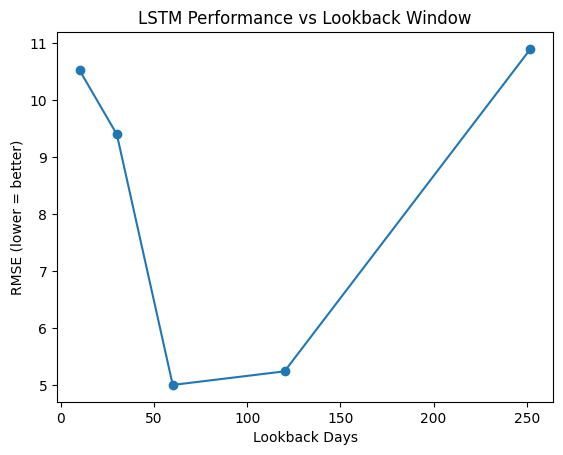

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# 1️⃣ Download stock data
data = yf.download("AAPL", start="2015-01-01", end="2025-01-01")
close_prices = data['Close'].values.reshape(-1, 1)

# 2️⃣ Scale prices (LSTM works better with normalized data)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

# Function to create LSTM-ready sequences
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i - lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

# Split into train and test sets
train_size = int(len(scaled_data) * 0.8)
train, test = scaled_data[:train_size], scaled_data[train_size:]

lookbacks = [10, 30, 60, 120, 252]  # 2 weeks, 1 month, 2 months, 6 months, 1 year
results = []

for lookback in lookbacks:
    X_train, y_train = create_sequences(train, lookback)
    X_test, y_test = create_sequences(test, lookback)

    # Reshape input for LSTM: [samples, timesteps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # 3️⃣ Build simple LSTM model
    model = Sequential([
        LSTM(50, return_sequences=False, input_shape=(lookback, 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # 4️⃣ Train model
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # 5️⃣ Evaluate
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))

    rmse = np.sqrt(mean_squared_error(y_test_rescaled, predictions))
    results.append((lookback, rmse))

    print(f"✅ Lookback {lookback} days → RMSE: {rmse:.4f}")

# 6️⃣ Display comparison
result_df = pd.DataFrame(results, columns=["Lookback_Days", "RMSE"])
print(result_df)

# Optional: plot RMSE vs lookback
plt.plot(result_df["Lookback_Days"], result_df["RMSE"], marker='o')
plt.title("LSTM Performance vs Lookback Window")
plt.xlabel("Lookback Days")
plt.ylabel("RMSE (lower = better)")
plt.show()
